In [ ]:
#| default_exp dtcam

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from IPython.display import Image
from llmcam.gpt4v import ask_gpt4v
from llmcam.fn_to_fc import *

In [ ]:
#| export
import requests
from pathlib import Path
from PIL import Image
from io import BytesIO
from datetime import datetime

In [ ]:
#| export
stations_url = "https://tie.digitraffic.fi/api/weathercam/v1/stations"

In [ ]:
#| export
def stations(key:str)->list[dict]:
    "Get all weather station including `key` word"
    res = requests.get(stations_url)
    assert res.status_code == 200
    stations = res.json()['features']
    return [st for st in stations if key.lower() in st['properties']['name'].lower()]

In [ ]:
Porvoos = stations("Porvoo")
assert "porvoo" in Porvoos[0]['properties']['name'].lower()

In [ ]:
#| export
def presets(station:dict)->list[dict]:
    "Get all presets at a given weather station"
    res = requests.get(stations_url + "/" + station['id'])
    assert res.status_code == 200
    presets = res.json()['properties']['presets']
    return presets

In [ ]:
preset = presets(Porvoos[0])[0]
imageUrl = preset['imageUrl']
print(imageUrl)
assert "jpg" in imageUrl

https://weathercam.digitraffic.fi/C0150200.jpg


In [ ]:
#| export
def capture(preset:dict)->Path:
    "Capture image at a given preset location in a Weather station, and return an image path"
    req = requests.get(preset['imageUrl'], headers={'Digitraffic-User': 'NinjaLABO/LLMCAM 1.0'})
    assert req.status_code == 200
    img = Image.open(BytesIO(req.content))
    #img.show()
    dt = datetime.strptime(req.headers["last-modified"], '%a, %d %b %Y %H:%M:%S %Z')
    dtstr = dt.strftime("%Y.%m.%d_%H:%M:%S")
    path = f"../data/cap_{dtstr}_{preset['presentationName']}_{preset['id']}.jpg"
    img.save(path, format="JPEG")
    return req.headers, path

In [ ]:
preset

{'id': 'C0150200',
 'presentationName': 'Porvoo',
 'inCollection': True,
 'resolution': '704x576',
 'directionCode': '0',
 'imageUrl': 'https://weathercam.digitraffic.fi/C0150200.jpg',
 'direction': 'UNKNOWN'}

In [ ]:
hdr, path = capture(preset)
hdr

{'Content-Type': 'image/jpeg', 'Content-Length': '100773', 'Connection': 'keep-alive', 'x-amz-id-2': 'udJm0v/5Z8XDNQ9YXMxeB7qj36yY1x0gIAAoRbJ4I+IZGkk7eBMlEvAdWNE1laEkbsnXf9nLJVY=', 'x-amz-request-id': '7X75DNF0D7JJD6RV', 'last-modified': 'Wed, 13 Nov 2024 12:12:00 GMT', 'x-amz-expiration': 'expiry-date="Fri, 15 Nov 2024 00:00:00 GMT", rule-id="Delete versions and current images after 24h"', 'x-amz-server-side-encryption': 'AES256', 'X-Amz-Meta-Last-Modified': 'Wed, 13 Nov 2024 12:12:00 GMT', 'x-amz-version-id': 'vQUS0joZWoM3UErjV2zKDIXHiOuCE1ah', 'Accept-Ranges': 'bytes', 'Server': 'AmazonS3', 'Date': 'Wed, 13 Nov 2024 12:19:03 GMT', 'ETag': '"f30f308e913f51ede7c09b5af2c4e32d"', 'Vary': 'Accept-Encoding', 'X-Cache': 'Hit from cloudfront', 'Via': '1.1 c5986ba12cee41e584b5d9b9a9b15446.cloudfront.net (CloudFront)', 'X-Amz-Cf-Pop': 'HEL51-P1', 'Alt-Svc': 'h3=":443"; ma=86400', 'X-Amz-Cf-Id': 'G4cjiN3tzUZV-M1TS7ywXrQ7bzoL8Jcpd56WA3Y19Y_RHFn0UrdtoQ==', 'Age': '8'}

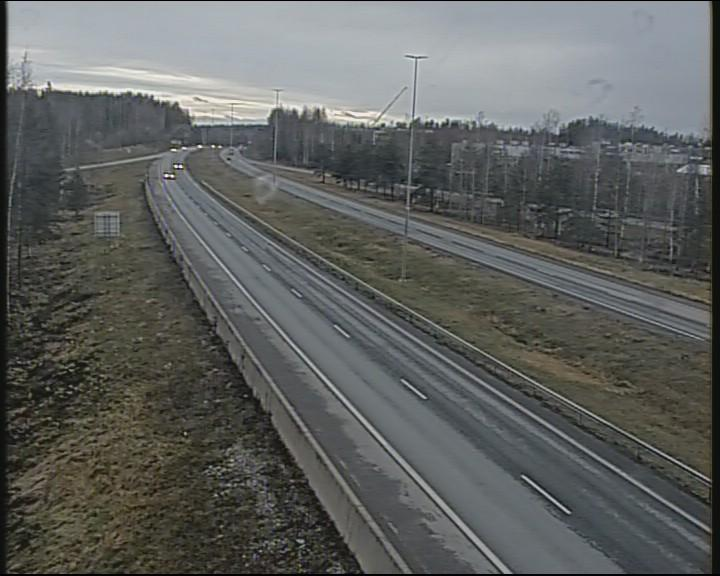

In [ ]:
display(Image.open(path))

In [ ]:
#| export
def cap(
    key:str, # location keyword
)->str:
    "Capture an image at specified location, save it, and return its path"
    _, path = capture(presets(stations("Porvoo")[0])[0])
    return str(path)

In [ ]:
show_doc(cap)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/dtcam.py#L46){target="_blank" style="float:right; font-size:smaller"}

### cap

>      cap (key:str)

*Capture an image at specified location, save it, and return its path*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| key | str | location keyword |
| **Returns** | **str** |  |

In [ ]:
#| eval: false
path = cap("porvoo")
print(path)
ask_gpt4v(path)

../data/cap_2024.11.13_12:12:00_Porvoo_C0150200.jpg


{'timestamp': 'unknown',
 'location': 'unknown',
 'dimensions': {'width': 720, 'height': 576},
 'buildings': {'number_of_buildings': 0, 'building_height_range': '0 stories'},
 'vehicles': {'number_of_vehicles': 3, 'types': ['cars']},
 'waterbodies': {'visible': False, 'type': 'none', 'number_of_boats': 0},
 'street_lights': {'number_of_street_lights': 4},
 'people': {'approximate_number': 0},
 'lighting': {'time_of_day': 'daytime', 'artificial_lighting': 'minimal'},
 'visibility': {'clear': True},
 'sky': {'visible': True, 'light_conditions': 'overcast'}}

In [ ]:
def __ask_gpt4v(
    path: str # file path to analyze
)->str:
    "ask gpt4v to analyze an image given"
    return str(ask_gtp4v(path))

In [ ]:
tools = [tool_schema(f) for f in [cap, __ask_gpt4v] ]
tools

[{'type': 'function',
  'function': {'name': 'cap',
   'description': 'Capture an image at specified location, save it, and return its path',
   'parameters': {'type': 'object',
    'properties': {'key': {'type': 'string',
      'description': 'location keyword'}},
    'required': ['key']}}},
 {'type': 'function',
  'function': {'name': '__ask_gpt4v',
   'description': 'ask gpt4v to analyze an image given',
   'parameters': {'type': 'object',
    'properties': {'path': {'type': 'string',
      'description': 'file path to analyze'}},
    'required': ['path']}}}]

In [ ]:
def callback(*args, **kargs): return cap(kargs.get('key'))

In [ ]:
#| eval: false
msgs = [form_msg("system", "You are a helpful system administrator. Use the supplied tools to assist the user.")]
msgs.append(form_msg("user", "Capture an image in Porvoo and tell me the path"))
complete(msgs, tools=tools, aux_fn=callback)
file = f"{msgs[-1]['content'][-54:]}"
print(file)

`../data/cap_2024.11.13_12:12:00_Porvoo_C0150200.jpg`.


In [ ]:
#| eval: false
msgs.append(form_msg("user", f"analyze this captured image, {file}"))
complete(msgs, tools=tools, aux_fn=callback)

('assistant',
 'The captured image from Porvoo has been analyzed, and the analysis has been saved at the path: `../data/cap_2024.11.13_12:12:00_Porvoo_C0150200.jpg`.')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()